## Dataset Download

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 308M/309M [00:17<00:00, 17.5MB/s]
100% 309M/309M [00:17<00:00, 18.6MB/s]


In [4]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

## Library Imports

In [5]:
import cv2
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Resizing, Rescaling, Input, Conv2D, BatchNormalization,
             MaxPool2D, Flatten, Dense, Dropout, RandomRotation, RandomFlip, RandomContrast)
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import confusion_matrix

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

## Dataset Loading

In [6]:
train_dataset_path = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_dataset_path = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry","happy","sad"]

In [7]:
CONFIGURATION = {
    "IM_SIZE":256,
    "BATCH_SIZE":32,
    "SEED":123,
    "LEARNING_RATE":0.001,
    "N_EPOCHS" : 20,
    "DROPOUT_RATE":0.0,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":100,
    "N_DENSE_2":10,
    "NUM_CLASSES":3,
}

In [8]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    color_mode="rgb",
    batch_size=CONFIGURATION['BATCH_SIZE'],
    class_names=CLASS_NAMES,
    shuffle=True,
    seed=123
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    color_mode="rgb",
    batch_size=CONFIGURATION['BATCH_SIZE'],
    class_names=CLASS_NAMES,
    shuffle=True,
    seed=123
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [9]:
for i in validation_dataset.take(1):
  print(i)

# if labels="categorical" class will be look like [0 0 1], [1 0 0]

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.16875000e+01, 4.16875000e+01, 4.16875000e+01],
         ...,
         [2.37500000e+00, 2.37500000e+00, 2.37500000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
         [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],

        [[4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.16875000e+01, 4.16875000e+01, 4.16875000e+01],
         ...,
         [2.12109375e+00, 2.12109375e+00, 2.12109375e+00],
         [1.87500000e-01, 1.87500000e-01, 1.87500000e-01],
         [1.87500000e-01, 1.87500000e-01, 1.87500000e-01]],

        [[4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.10000000e+01, 4.10000000e+01, 4.10000000e+01],
         [4.16875000e+01, 4.16875000e+01, 4.16875000e+01],
         ...,
         

## Data Visualization

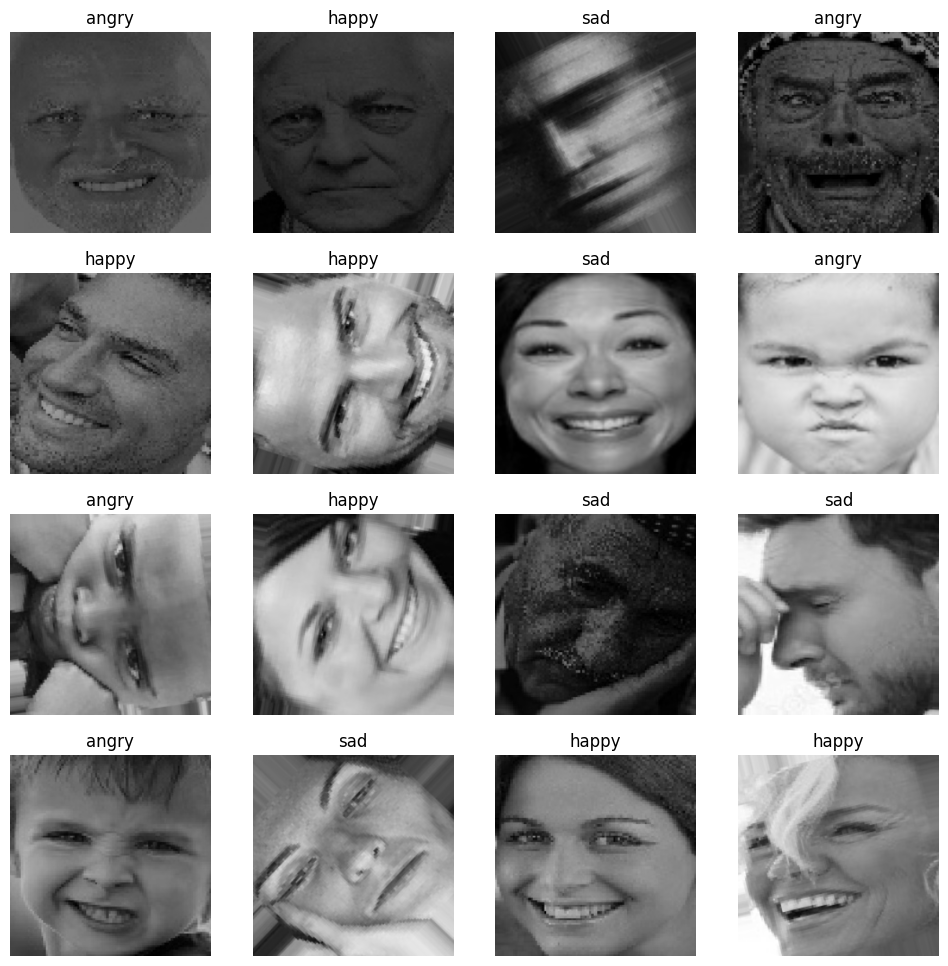

In [10]:
plt.figure(figsize=(12,12))

for images,labels in training_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[labels[i].numpy()])
        plt.axis("off")

## Data Augmentation

In [11]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025,0.025),),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
])
# factor 0.025 means 0.025*360 = 9 -> image will take random rotation of 9 degree.

In [12]:
@tf.function
def augment_layer(image,label):
    return augment_layers(image,training=True),label

### Cutmix augmentation

In [13]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [14]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Dataset Preparation

In [15]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [16]:
# we do augmantation only for training data
train_data = (training_dataset
              .map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
              .prefetch(tf.data.AUTOTUNE))
val_data = (validation_dataset.prefetch(tf.data.AUTOTUNE))

In [17]:
resize_rescale_layer = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    Rescaling(1./255)
])

### Cutmix Data Preparation

In [18]:
cutmix_dataset_1 = training_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
cutmix_dataset_2 = training_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((cutmix_dataset_1,cutmix_dataset_2))

In [19]:
cutmix_train_data = (mixed_dataset
                        .map(cutmix,num_parallel_calls=tf.data.AUTOTUNE)
                        .prefetch(tf.data.AUTOTUNE))

## Modeling

In [20]:
model = tf.keras.Sequential([
    Input(shape=(None,None,3)),
    resize_rescale_layer,

    Conv2D(filters=CONFIGURATION["N_FILTERS"], kernel_size=CONFIGURATION["KERNEL_SIZE"],strides=CONFIGURATION["N_STRIDES"],
           padding='valid',activation='relu',kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"],strides=CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate=CONFIGURATION["DROPOUT_RATE"]),

    Conv2D(filters=CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size=CONFIGURATION["KERNEL_SIZE"],strides=CONFIGURATION["N_STRIDES"],
           padding='valid',activation='relu',kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D(pool_size=CONFIGURATION["POOL_SIZE"],strides=CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense(CONFIGURATION["N_DENSE_1"], activation="relu",kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate=CONFIGURATION['DROPOUT_RATE']),

    Dense(CONFIGURATION["N_DENSE_2"], activation="relu",kernel_regularizer=L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

## Training

In [21]:
loss_function = SparseCategoricalCrossentropy()

### Difference between SparseCategoricalCrossentropy and CategoricalCrossentropy

In [22]:
y_true = [[0,1,0],[0,0,1]]
y_pred = [[0.05,0.95,0],[0.1,0.8,0.1]]
cce = CategoricalCrossentropy()
cce(y_true,y_pred).numpy()

1.1769392

In [23]:
y_true = [[0,1,0],[0,0,1]]
y_pred = [[0.05,0.95,0],[0.1,0.8,0.1]]
cce = SparseCategoricalCrossentropy()   # will give error
cce(y_true,y_pred).numpy()

ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(6,) and logits.shape=(2, 3)

In [24]:
y_true = [1,2]
y_pred = [[0.05,0.95,0],[0.1,0.8,0.1]]
cce = SparseCategoricalCrossentropy()   # will give error
cce(y_true,y_pred).numpy()

1.1769392

In [25]:
metrics = [CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2,name="top_k_accuracy")]

In [26]:
model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics
)

In [27]:
history = model.fit(cutmix_train_data,   # use only train data if not applying augmentation
                    # epochs=1,
                    epochs=CONFIGURATION["N_EPOCHS"],
                    validation_data=val_data,
                    verbose=1)

Epoch 1/20
213/213 [==============================] - 121s 512ms/step - loss: 1.0357 - accuracy: 0.2836 - top_k_accuracy: 0.7214 - val_loss: 1.1233 - val_accuracy: 0.0105 - val_top_k_accuracy: 0.9697
Epoch 2/20
213/213 [==============================] - 111s 514ms/step - loss: 0.9078 - accuracy: 0.1830 - top_k_accuracy: 0.8707 - val_loss: 1.1636 - val_accuracy: 0.0913 - val_top_k_accuracy: 0.9921
Epoch 3/20
213/213 [==============================] - 108s 494ms/step - loss: 0.8769 - accuracy: 0.1752 - top_k_accuracy: 0.8906 - val_loss: 1.1359 - val_accuracy: 0.2248 - val_top_k_accuracy: 0.9543
Epoch 4/20
213/213 [==============================] - 111s 516ms/step - loss: 0.8741 - accuracy: 0.1850 - top_k_accuracy: 0.8834 - val_loss: 1.1535 - val_accuracy: 0.1212 - val_top_k_accuracy: 0.9249
Epoch 5/20
213/213 [==============================] - 108s 499ms/step - loss: 0.8501 - accuracy: 0.1828 - top_k_accuracy: 0.8923 - val_loss: 1.0858 - val_accuracy: 0.1857 - val_top_k_accuracy: 0.8824


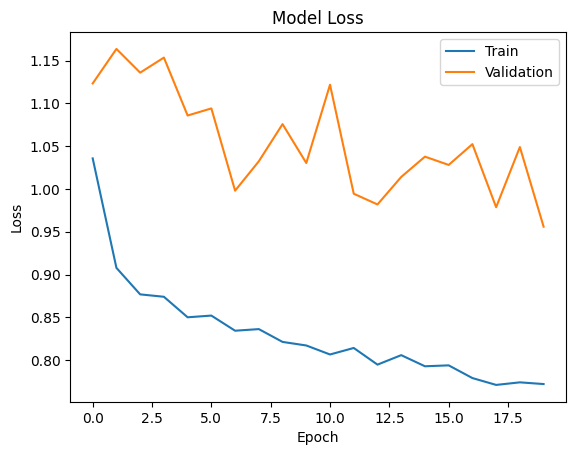

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

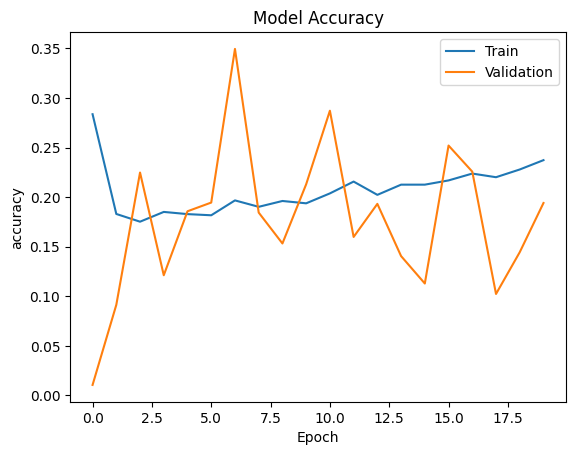

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluation

In [33]:
model.evaluate(val_data)

72/72 [==============================] - 3s 34ms/step - loss: 0.9560 - accuracy: 0.1940 - top_k_accuracy: 0.7169


[0.955977201461792, 0.19402985274791718, 0.7168568968772888]

## Testing

In [34]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/104188.jpg_rotation_2.jpg")
im = tf.constant(test_image,dtype=tf.float32)
im = tf.expand_dims(im,axis=0)

print(CLASS_NAMES[tf.argmax(model(im),axis=-1).numpy()[0]])

angry


In [35]:
# sad example
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/10416.jpg_rotation_2.jpg")
im = tf.constant(test_image,dtype=tf.float32)
im = tf.expand_dims(im,axis=0)

print(CLASS_NAMES[tf.argmax(model(im),axis=-1).numpy()[0]])

happy


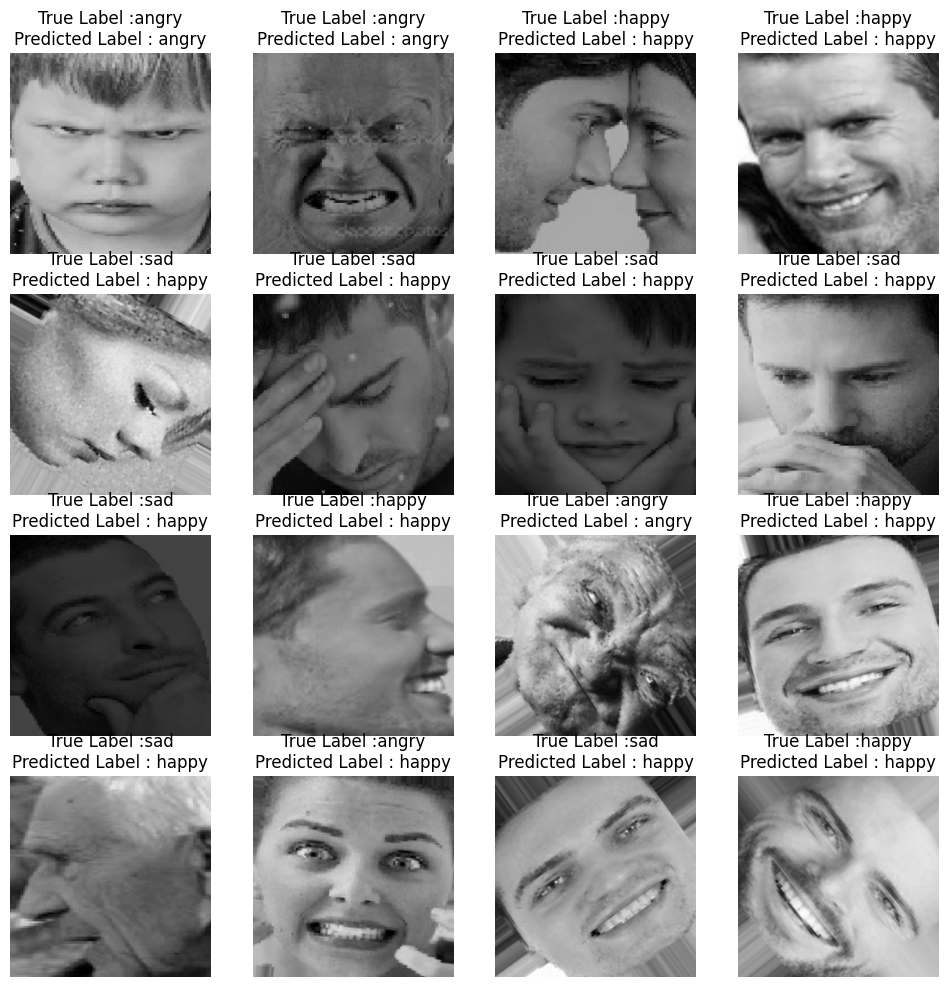

In [36]:
plt.figure(figsize=(12,12))

for images,labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label :" + CLASS_NAMES[labels[i].numpy()] + "\n" + "Predicted Label : "+ CLASS_NAMES[tf.argmax(model(tf.expand_dims(images[i],axis=0)),axis=-1).numpy()[0]])
        plt.axis("off")

## Confusion Matrix

In [37]:
labels = []
predicted = []
for im, label in validation_dataset:
    labels.append(label.numpy())
    predicted.append(tf.argmax(model(im),axis=-1).numpy())

In [38]:
lab = np.concatenate(labels)
pred = np.concatenate(predicted)

In [ ]:
lab

[[302 213   0]
 [ 82 923   1]
 [ 58 686  13]]


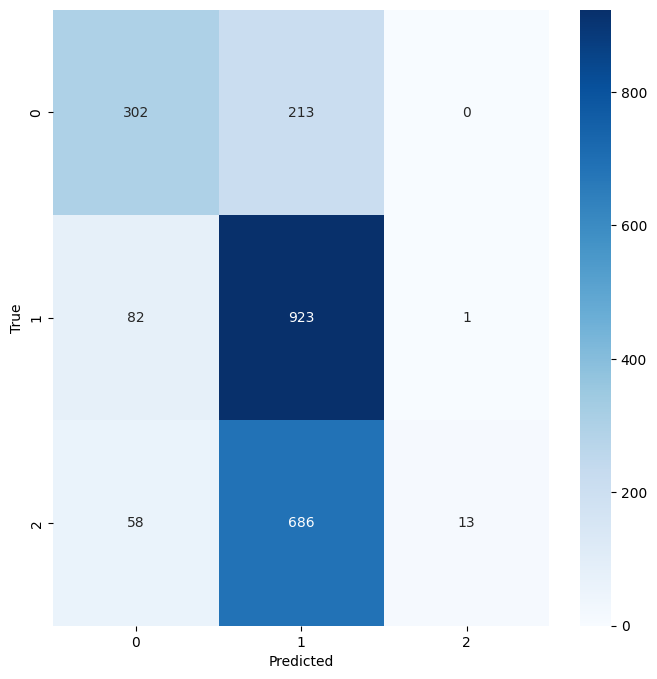

In [39]:
threshold = 0.5

cm = confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Converting model to onnx format.

onnx optimize model size and comparatively faster then tensorflow, keras and other DL Frameworks.

In [43]:
# saving model in tf format
model.save("human_emotion_model")

### install onnx

In [41]:
!pip install -U tf2onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.8 MB/s eta 0:00:00


In [44]:
### Tensorflow Model Conversion

!python -m tf2onnx.convert --saved-model human_emotion_model/ --output human_emotion_model.onnx

2024-05-21 07:19:39.728970: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 07:19:39.729041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 07:19:39.730404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 07:19:40.855311: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2

In [ ]:
## saving model in keras h5 format
model.save("human_emotion_model.h5")

In [45]:
import tf2onnx
import onnxruntime as ort

spec = (tf.TensorSpec(
    (None,CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3),
    tf.float32, name="input"),)

output_path = "human_emotion_model_from_h5.onnx"

model_proto,_ = tf2onnx.convert.from_keras(model,input_signature=spec,opset=13,output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

### Inference

In [58]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/104188.jpg_rotation_2.jpg")
test_image = cv2.resize(test_image,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
# im = tf.constant(test_image,dtype=tf.float32)
im = test_image.astype(np.float32)

im = np.expand_dims(im,axis=0)


In [59]:
type(im[0][0][0][0])

numpy.float32

In [60]:

providers = ["CPUExecutionProvider"]
sess = ort.InferenceSession(output_path,providers=providers)

onnx_pred = sess.run(output_names,{"input":im})

In [61]:
onnx_pred

[array([[0.5777089 , 0.33269817, 0.0895929 ]], dtype=float32)]